In [3]:
import tkinter as tk
from tkinter import ttk, messagebox, Button, scrolledtext, Scale, Checkbutton, Label
import googletrans
import threading
import time  # For introducing pauses
import random  # For slight variations
import simpleaudio as sa
import soundfile as sf
import librosa
import numpy as np
import noisereduce  # Import the noisereduce library
import io  # Import the io module
from PIL import Image, ImageTk  # For image display
from gtts import gTTS

# Initialize translator
translator = googletrans.Translator()

language_options = {
    "Amharic": "am", "Arabic": "ar", "Armenian": "hy", "Azerbaijani": "az", "Belarusian": "be",
    "Bengali": "bn", "Bulgarian": "bg", "Burmese": "my", "Catalan": "ca", "Cebuano": "ceb",
    "Chichewa": "ny", "Chinese": "zh-CN", "Corsican": "co", "Czech": "cs", "Dari": "prs",
    "Dutch": "nl", "English": "en", "Esperanto": "eo", "Estonian": "et", "Finnish": "fi", "French": "fr",
    "Ga": "ga", "Georgian": "ka", "German": "de", "Greek": "el", "Gujarati": "gu", "Hausa": "ha",
    "Hawaiian Creole": "haw", "Hebrew": "he", "Hindi": "hi", "Hmong": "hmn", "Hungarian": "hu",
    "Icelandic": "is", "Igbo": "ig", "Indonesian": "id", "Irish": "ga", "Italian": "it", "Japanese": "ja",
    "Javanese": "jv", "Kannada": "kn", "Kazakh": "kk", "Khmer": "km", "Korean": "ko", "Kurdish": "ku",
    "Kyrgyz": "ky", "Lao": "lo", "Latin": "la", "Latvian": "lv", "Lithuanian": "lt", "Luxembourgish": "lb",
    "Macedonian": "mk", "Malagasy": "mg", "Malay": "ms", "Malayalam": "ml", "Maltese": "mt", "Maori": "mi",
    "Marathi": "mr", "Mongolian": "mn", "Nepali": "ne", "Norwegian": "no", "Pashto": "ps", "Persian": "fa",
    "Polish": "pl", "Portuguese": "pt", "Punjabi": "pa", "Romanian": "ro", "Russian": "ru", "Samoan": "sm",
    "Scottish Gaelic": "gd", "Serbian": "sr", "Shona": "sn", "Sindhi": "sd", "Sinhala": "si", "Slovak": "sk",
    "Slovenian": "sl", "Somali": "so", "Sotho": "st", "Spanish": "es", "Sundanese": "su", "Swahili": "sw",
    "Swedish": "sv", "Tagalog": "tl", "Tajik": "tg", "Tamil": "ta", "Telugu": "te", "Thai": "th",
    "Tibetan": "bo", "Turkish": "tr", "Turkmen": "tk", "Ukrainian": "uk", "Urdu": "ur", "Uzbek": "uz",
    "Vietnamese": "vi", "Welsh": "cy", "West Frisian": "fy", "Xhosa": "xh", "Yiddish": "yi", "Yoruba": "yo",
    "Zulu": "zu"
}


def enhance_speech_realism(text, target_language='en', enhancement_level='medium', speed_factor=1.0, volume_factor=1.0):
    """
    Enhances the realism of speech generated from translated text using gTTS.

    Args:
        text (str): The text to translate and convert to speech.
        target_language (str): The target language code.
        enhancement_level (str): The level of enhancement to apply.
        speed_factor (float): Multiplier for speech speed.
        volume_factor (float): Multiplier for volume.

    Returns:
        tuple: (translated_text, audio_data, sample_rate) on success, (None, None, None) on error.
    """
    try:
        translator = googletrans.Translator()
        translation = translator.translate(text, dest=target_language)
        translated_text = translation.text

        tts = gTTS(text=translated_text, lang=target_language)
        audio_mem = io.BytesIO()
        tts.write_to_fp(audio_mem)
        audio_mem.seek(0)

        audio_data, sample_rate = sf.read(audio_mem)

        if enhancement_level == 'none':
            print("No enhancement applied.")
            return translated_text, audio_data, sample_rate

        elif enhancement_level == 'medium':
            print("Applying medium enhancement: Noise reduction and speed variation.")
            try:
                reduced_noise_audio = noisereduce.reduce_noise(y=audio_data, sr=sample_rate)
            except Exception as e:
                print(f"Error during noise reduction: {e}. Skipping noise reduction.")
                reduced_noise_audio = audio_data
            stretched_audio = librosa.effects.time_stretch(reduced_noise_audio, rate=speed_factor)
            return translated_text, stretched_audio * volume_factor, sample_rate

        elif enhancement_level == 'high':
            print("Applying high enhancement: Noise reduction, speed/pitch variation, and reverb.")
            try:
                reduced_noise_audio = noisereduce.reduce_noise(y=audio_data, sr=sample_rate)
            except Exception as e:
                print(f"Error during noise reduction: {e}. Skipping noise reduction.")
                reduced_noise_audio = audio_data
            stretched_audio = librosa.effects.time_stretch(reduced_noise_audio, rate=speed_factor)
            pitched_audio = librosa.effects.pitch_shift(stretched_audio, sr=sample_rate, n_steps=1.02)
            reverbed_audio = pitched_audio + 0.02 * librosa.effects.room_effects(pitched_audio, sample_rate)
            return translated_text, reverbed_audio * volume_factor, sample_rate
        else:
            print("Invalid enhancement level. Returning original gTTS output.")
            return translated_text, audio_data * volume_factor, sample_rate

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None


class AudioPlayer:
    def __init__(self, master, play_image_path="play.png", pause_image_path="pause.png"):
        self.master = master
        self.playing = False
        self.audio_data = None
        self.sample_rate = None
        self.play_obj = None
        self.current_frame = 0
        self.total_frames = 0

        try:
            play_img = Image.open(play_image_path).resize((30, 30))
            self.play_icon = ImageTk.PhotoImage(play_img)
            pause_img = Image.open(pause_image_path).resize((30, 30))
            self.pause_icon = ImageTk.PhotoImage(pause_img)
        except FileNotFoundError:
            print("Error: Play or pause image not found. Using text buttons.")
            self.play_icon = None
            self.pause_icon = None

        self.audio_frame = ttk.Frame(master)
        self.audio_frame.pack(pady=10, fill='x')

        if self.play_icon and self.pause_icon:
            self.play_pause_button = ttk.Button(self.audio_frame, image=self.play_icon, command=self.toggle_play_pause)
        else:
            self.play_pause_button = ttk.Button(self.audio_frame, text="Play", command=self.toggle_play_pause)
        self.play_pause_button.pack(side=tk.LEFT, padx=5)

        self.progress_var = tk.DoubleVar()
        self.progress_bar = ttk.Scale(self.audio_frame, variable=self.progress_var, from_=0, to=100,
                                      orient=tk.HORIZONTAL, command=self.seek_audio)
        self.progress_bar.pack(side=tk.LEFT, fill='x', expand=True, padx=5)

        self.volume_var = tk.DoubleVar(value=100)
        self.volume_scale = Scale(self.audio_frame, from_=0, to=100, orient=tk.HORIZONTAL, label="Volume",
                                  command=self.set_volume, variable=self.volume_var, showvalue=False, width=80)
        self.volume_scale.pack(side=tk.LEFT, padx=5)

        self.mute_var = tk.BooleanVar(value=False)
        self.mute_check = Checkbutton(self.audio_frame, text="Mute", variable=self.mute_var, command=self.toggle_mute)
        self.mute_check.pack(side=tk.LEFT, padx=5)

    def set_audio(self, audio_data, sample_rate):
        self.audio_data = (audio_data * 32767).astype(np.int16)
        self.sample_rate = sample_rate
        self.total_frames = len(self.audio_data)
        self.current_frame = 0
        self.progress_var.set(0)
        if self.playing:
            self.stop_audio()
        if self.play_icon:
            self.play_pause_button.config(image=self.play_icon)
        else:
            self.play_pause_button.config(text="Play")
        self.playing = False

    def toggle_play_pause(self):
        if self.audio_data is None:
            return
        if not self.playing:
            self.play_audio()
        else:
            self.pause_audio()

    def play_audio(self):
        if self.playing or self.audio_data is None:
            return
        try:
            self.play_obj = sa.play_buffer(
                self.audio_data[self.current_frame:],
                self.audio_data.ndim, 2, self.sample_rate
            )
            self.playing = True
            if self.pause_icon:
                self.play_pause_button.config(image=self.pause_icon)
            else:
                self.play_pause_button.config(text="Pause")
            self.update_progress()
        except Exception as e:
            print(f"Error playing audio: {e}")
            self.playing = False
            if self.play_icon:
                self.play_pause_button.config(image=self.play_icon)
            else:
                self.play_pause_button.config(text="Play")

    def pause_audio(self):
        if self.playing and self.play_obj:
            try:
                self.play_obj.stop()
            except Exception as e:
                print(f"Error pausing audio: {e}")
            self.playing = False
            if self.play_icon:
                self.play_pause_button.config(image=self.play_icon)
            else:
                self.play_pause_button.config(text="Play")

    def stop_audio(self):
        if self.playing and self.play_obj:
            try:
                self.play_obj.stop()
            except Exception as e:
                print(f"Error stopping audio: {e}")
            self.play_obj = None
        self.playing = False
        if self.play_icon:
            self.play_pause_button.config(image=self.play_icon)
        else:
            self.play_pause_button.config(text="Play")
        self.current_frame = 0
        self.progress_var.set(0)

    def seek_audio(self, value):
        if self.audio_data and self.total_frames:
            seek_percentage = float(value) / 100
            self.current_frame = int(self.total_frames * seek_percentage)
            if self.playing and self.play_obj:
                self.play_obj.stop()
                self.play_audio()

    def set_volume(self, value):
        self.volume = int(value) / 100.0
        if self.playing and self.play_obj:
            self.play_obj.stop()
            self.play_audio()  # Replay with new volume (simpleaudio doesn't have dynamic volume control)

    def toggle_mute(self):
        self.mute = self.mute_var.get()
        if self.playing and self.play_obj:
            self.play_obj.stop()
            self.play_audio()

    def get_current_volume(self):
        return 0 if self.mute_var.get() else self.volume_var.get() / 100.0

    def update_progress(self):
        if self.playing and self.play_obj:
            try:
                played_frames = self.total_frames - self.play_obj.get_remaining_frames()
                if self.total_frames > 0:
                    progress = (played_frames / self.total_frames) * 100
                    self.progress_var.set(progress)
                    if self.playing:
                        self.master.after(100, self.update_progress)
                    else:
                        self.current_frame = self.total_frames
            except Exception as e:
                print(f"Error updating progress: {e}")
                self.stop_audio()


def translate_text():
    text_to_translate = text_input.get("1.0", tk.END).strip()
    selected_language_code = language_var.get()
    try:
        translation = translator.translate(text_to_translate, dest=language_options[selected_language_code]).text
        translated_text_display.config(state=tk.NORMAL)
        translated_text_display.delete("1.0", tk.END)
        translated_text_display.insert(tk.END, translation)
        translated_text_display.config(state=tk.DISABLED)
        play_enhanced_button.config(state=tk.NORMAL) # Enable the play button after translation
    except Exception as e:
        messagebox.showerror("Translation Error", f"Could not translate: {e}")
        translated_text_display.config(state=tk.NORMAL)
        translated_text_display.delete("1.0", tk.END)
        translated_text_display.insert(tk.END, "Translation Error")
        translated_text_display.config(state=tk.DISABLED)
        play_enhanced_button.config(state=tk.DISABLED)

def play_enhanced_speech():
    text_to_speak = translated_text_display.get("1.0", tk.END).strip()
    selected_language_code = language_var.get()
    enhancement_level = "medium"  # You can add a UI element for this later
    speed = 1.0  # You can add a UI element for this later
    volume = 1.0  # You can add a UI element for this later

    if text_to_speak:
        translated_text, audio_data, sample_rate = enhance_speech_realism(
            text_to_speak, language_options[selected_language_code], enhancement_level, speed, volume
        )
        if audio_data is not None and sample_rate is not None:
            audio_player.set_audio(audio_data, sample_rate)
            audio_player.play_audio()
        else:
            messagebox.showerror("Speech Error", "Error generating enhanced speech.")
    else:
        messagebox.showinfo("Info", "No translated text to speak.")

def highlight_spoken_text_enhanced():
    text_to_highlight = translated_text_display.get("1.0", "end-1c")
    audio_data = audio_player.audio_data
    sample_rate = audio_player.sample_rate

    if audio_data is None or sample_rate is None:
        messagebox.showinfo("Info", "No audio is currently loaded.")
        return

    words = text_to_highlight.split()
    total_duration = len(audio_data) / sample_rate if sample_rate > 0 else 0
    word_durations = []
    if words and total_duration > 0 and len(words) > 0:
        word_durations = [total_duration / len(words)] * len(words) # Simple approximation

    translated_text_display.tag_configure("speaking", background="blue", foreground="black")

    def _highlight_thread():
        current_time = 0
        translated_text_display.tag

my own 


In [ ]:
pip install gtts googletrans soundfile librosa numpy noisereduce

In [ ]:
pip install simpleaudio 

In [ ]:
import tkinter as tk
from tkinter import ttk
from gtts import gTTS
from googletrans import Translator
import soundfile as sf
import librosa
import numpy as np
import noisereduce
import threading

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox, Button
import pyttsx3
import googletrans
import threading
import time  # For introducing pauses
import random # For slight variations

In [ ]:
# List of supported languages and their codes (expanded)
language_options = {
    "Amharic": "am",
    "Arabic": "ar",
    "Armenian": "hy",
    "Azerbaijani Rasour": "az",  # Assuming Azerbaijani
    "Belarusian": "be",
    "Bengali": "bn",
    "Bulgarian": "bg",
    "Burmese": "my",
    "Catalan": "ca",
    "Cebuano": "ceb",
    "Chichewa": "ny",
    "Chinese": "zh-CN",  # Simplified Chinese as default
    "Corsican": "co",
    "Czech": "cs",
    "Dari": "prs",
    "Dutch": "nl",
    "English": "en",
    "Esperanto": "eo",
    "Estonian": "et",
    "Finnish": "fi",
    "Flemish": "nl",  # Treated as Dutch
    "French": "fr",
    "Ga": "ga",
    "Georgian": "ka",
    "German": "de",
    "Greek": "el",
    "Gujarati": "gu",
    "Hausa": "ha",
    "Hawaiian Creole": "haw",
    "Hebrew": "he",
    "Hindi": "hi",
    "Hmong": "hmn",
    "Hungarian": "hu",
    "Icelandic": "is",
    "Igbo": "ig",
    "Indonesian": "id",
    "Irish": "ga",
    "Italian": "it",
    "Japanese": "ja",
    "Javanese": "jv",
    "Kannada": "kn",
    "Kazakh": "kk",
    "Khmer": "km",
    "Korean": "ko",
    "Kurdish": "ku",
    "Kyrgyz": "ky",
    "Lao": "lo",
    "Latin": "la",
    "Latvian": "lv",
    "Lithuanian": "lt",
    "Luxembourgish": "lb",
    "Macedonian": "mk",
    "Malagasy": "mg",
    "Malay": "ms",
    "Malayalam": "ml",
    "Maltese": "mt",
    "Maori": "mi",
    "Marathi": "mr",
    "Mongolian": "mn",
    "Nepali": "ne",
    "Norwegian": "no",
    "Pashto": "ps",
    "Persian": "fa",
    "Polish": "pl",
    "Portuguese": "pt",
    "Punjabi": "pa",
    "Romanian": "ro",
    "Russian": "ru",
    "Samoan": "sm",
    "Scottish Gaelic": "gd",
    "Serbian": "sr",
    "Shona": "sn",
    "Sindhi": "sd",
    "Sinhala": "si",
    "Slovak": "sk",
    "Slovenian": "sl",
    "Somali": "so",
    "Sotho": "st",
    "Spanish": "es",
    "Sundanese": "su",
    "Swahili": "sw",
    "Swedish": "sv",
    "Tagalog": "tl",
    "Tajik": "tg",
    "Tamil": "ta",
    "Telugu": "te",
    "Thai": "th",
    "Tibetan": "bo",
    "Turkish": "tr",
    "Turkmen": "tk",
    "Ukrainian": "uk",
    "Urdu": "ur",
    "Uzbek": "uz",
    "Vietnamese": "vi",
    "Welsh": "cy",
    "West Frisian": "fy",
    "Xhosa": "xh",
    "Yiddish": "yi",
    "Yoruba": "yo",
    "Zulu": "zu"
}

In [ ]:
# Create the main window
root = tk.Tk()
root.title("PLAY~TTS")
root.geometry("400x550")
root.configure(bg="#f0ffff")


In [ ]:
trial

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox, Button
import pyttsx3
import googletrans
import threading
import time
import random

# Initialize TTS engine and translator
tts = pyttsx3.init()
translator = googletrans.Translator()

# List of supported languages and their codes
language_options = {
    "Amharic": "am", "Arabic": "ar", "Armenian": "hy", "Azerbaijani": "az",
    "Belarusian": "be", "Bengali": "bn", "Bulgarian": "bg", "Burmese": "my",
    "Catalan": "ca", "Cebuano": "ceb", "Chichewa": "ny", "Chinese": "zh-CN",
    "Corsican": "co", "Czech": "cs", "Dari": "prs", "Dutch": "nl", "English": "en",
    "Esperanto": "eo", "Estonian": "et", "Finnish": "fi", "Flemish": "nl",
    "French": "fr", "Ga": "ga", "Georgian": "ka", "German": "de", "Greek": "el",
    "Gujarati": "gu", "Hausa": "ha", "Hawaiian Creole": "haw", "Hebrew": "he",
    "Hindi": "hi", "Hmong": "hmn", "Hungarian": "hu", "Icelandic": "is",
    "Igbo": "ig", "Indonesian": "id", "Irish": "ga", "Italian": "it",
    "Japanese": "ja", "Javanese": "jv", "Kannada": "kn", "Kazakh": "kk",
    "Khmer": "km", "Korean": "ko", "Kurdish": "ku", "Kyrgyz": "ky",
    "Lao": "lo", "Latin": "la", "Latvian": "lv", "Lithuanian": "lt",
    "Luxembourgish": "lb", "Macedonian": "mk", "Malagasy": "mg", "Malay": "ms",
    "Malayalam": "ml", "Maltese": "mt", "Maori": "mi", "Marathi": "mr",
    "Mongolian": "mn", "Nepali": "ne", "Norwegian": "no", "Pashto": "ps",
    "Persian": "fa", "Polish": "pl", "Portuguese": "pt", "Punjabi": "pa",
    "Romanian": "ro", "Russian": "ru", "Samoan": "sm", "Scottish Gaelic": "gd",
    "Serbian": "sr", "Shona": "sn", "Sindhi": "sd", "Sinhala": "si",
    "Slovak": "sk", "Slovenian": "sl", "Somali": "so", "Sotho": "st",
    "Spanish": "es", "Sundanese": "su", "Swahili": "sw", "Swedish": "sv",
    "Tagalog": "tl", "Tajik": "tg", "Tamil": "ta", "Telugu": "te",
    "Thai": "th", "Tibetan": "bo", "Turkish": "tr", "Turkmen": "tk",
    "Ukrainian": "uk", "Urdu": "ur", "Uzbek": "uz", "Vietnamese": "vi",
    "Welsh": "cy", "West Frisian": "fy", "Xhosa": "xh", "Yiddish": "yi",
    "Yoruba": "yo", "Zulu": "zu"
}

# Create the main window
root = tk.Tk()
root.title("PLAY~TTS")
root.geometry("400x600")  # Increased height to accommodate output box
root.configure(bg="#f0ffff")

# Header
header = tk.Label(root, text="🟩PLAY~TTS", font=("Helvetica", 18, "bold"), bg="#f8f8f8")
header.pack(pady=10)

# Tabs (keeping for potential future use)
tab_frame = tk.Frame(root, bg="#f0ffff")
tab_frame.pack(pady=5)

text_to_speech_btn = tk.Button(tab_frame, text="Text to Speech", bg="#d1d1d1", width=20)
text_to_speech_btn.grid(row=0, column=0, padx=2)

# Settings
settings_label = tk.Label(root, text="Settings", font=("Helvetica", 12, "bold"), bg="#f0ffff")
settings_label.pack(pady=10)

# Language Dropdown
language_label = tk.Label(root, text="Target Language:", bg="#f3e8ff")
language_label.pack()
language_var = tk.StringVar()
languages = sorted(language_options.keys())
language_dropdown = ttk.Combobox(root, textvariable=language_var, values=languages)
language_dropdown.set("English")  # Set default to English
language_dropdown.pack(pady=5)

# Voice Dropdown
voice_label = tk.Label(root, text="Voice:", bg="#f8f8f8")
voice_label.pack()
voice_var = tk.StringVar()
voice_dropdown = ttk.Combobox(root, textvariable=voice_var, values=["Male", "Female"])
voice_dropdown.set("Male")  # Set default to Male
voice_dropdown.pack(pady=5)

# Voice Settings Dropdown
voice_settings_label = tk.Label(root, text="Voice Settings:", bg="#f8f8f8")
voice_settings_label.pack()
voice_settings_dropdown = ttk.Combobox(root, values=["Fast", "Medium", "Slow"])
voice_settings_dropdown.set("Medium")  # Set default to Medium
voice_settings_dropdown.pack(pady=5)

# Input Text Box
input_text_label = tk.Label(root, text="Input Text", bg="#f8f8f8")
input_text_label.pack()
input_text = tk.Text(root, height=5, width=40)
input_text.insert(tk.END, "Type or paste text here.")
input_text.pack(pady=5)

# Output Text Box
output_text_label = tk.Label(root, text="Translated Text", bg="#e0ffe0")
output_text_label.pack()
output_text = tk.Text(root, height=5, width=40, state=tk.DISABLED) # Disabled for display
output_text.pack(pady=5)

# Token Counter & Quota
quota_label = tk.Label(root, text="0 / 500 \u00A0\u00A0\u00A0\u00A0Total quota remaining: 50", bg="#f8f8f8")
quota_label.pack()

def translate_text_output():
    """Translates the input text and displays it in the output text box."""
    text = input_text.get("1.0", "end-1c").strip()
    language = language_var.get()

    if language in language_options:
        try:
            translated_text = translator.translate(text, dest=language_options[language]).text
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, translated_text)
            output_text.config(state=tk.DISABLED)
        except Exception as e:
            messagebox.showerror("Translation Error", f"Could not translate to {language}:\n{e}")
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
    else:
        output_text.config(state=tk.NORMAL)
        output_text.delete("1.0", tk.END)
        output_text.insert(tk.END, text) # If language not in options, show original
        output_text.config(state=tk.DISABLED)

def speak_humanized(text, rate=150, target_textbox=None):
    """Speaks text with slight pauses and rate variations, highlighting in the target textbox."""
    tts.setProperty('rate', rate)
    sentences = text.split('.')
    spoken_text_index = 0
    for sentence in sentences:
        words = sentence.strip().split()
        for i, word in enumerate(words):
            tts.say(word)
            if target_textbox:
                start_index = text.find(word, spoken_text_index)
                if start_index != -1:
                    end_index = start_index + len(word)
                    target_textbox.tag_add("speaking", f"1.{start_index}", f"1.{end_index}")
                    target_textbox.see(f"1.{start_index}")
                    spoken_text_index = end_index + 1
            tts.runAndWait()
            if target_textbox:
                target_textbox.tag_remove("speaking", "1.0", "end")
            if i < len(words) - 1 and ',' in sentence:
                time.sleep(0.05) # Short pause at commas
            elif i == len(words) - 1 and sentence.strip():
                time.sleep(0.1) # Slightly longer pause at sentence end

def speaknow():
    """
    Function to speak the translated text from the output text box with selected options,
    and highlight words in the output text box as they are spoken.
    """
    translated_text = output_text.get("1.0", "end-1c").strip()
    gender = voice_var.get()
    speed = voice_settings_dropdown.get()
    voices = tts.getProperty('voices')

    def setvoice():
        """Sets the voice based on the selected gender."""
        male_voice_id = None
        female_voice_id = None
        for voice in voices:
            if hasattr(voice, 'gender'):
                if voice.gender == 'male':
                    male_voice_id = voice.id
                elif voice.gender == 'female':
                    female_voice_id = voice.id
        if voice_var.get() == 'Female' and female_voice_id:
            tts.setProperty('voice', female_voice_id)
        elif voice_var.get() == 'Male' and male_voice_id:
            tts.setProperty('voice', male_voice_id)
        else:
            for voice in voices:
                if 'female' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            for voice in voices:
                if 'male' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            if voices:
                tts.setProperty('voice', voices[0].id)
                messagebox.showwarning("Voice Warning", "Could not determine voice gender. Using a default voice.")
            else:
                messagebox.showerror("TTS Error", "No voices available on your system.")

    if translated_text:
        # Adjust the speech rate
        if speed == 'Fast':
            tts.setProperty('rate', 200)
        elif speed == 'Medium':
            tts.setProperty('rate', 150)
        else:
            tts.setProperty('rate', 100)

        setvoice()
        output_text.tag_configure("speaking", background="blue", foreground="black")

        # Use a thread to prevent the GUI from freezing during highlighting and speech
        threading.Thread(target=speak_humanized, args=(translated_text, tts.getProperty('rate'), output_text)).start()

    else:
        messagebox.showwarning("No Text", "Please enter text and translate it first.")

# Bind the translation function to the "Text to Speech" button (renamed for clarity)
translate_button = Button(tab_frame, text="Translate", bg="#4CAF50", fg="white", width=20, command=translate_text_output)
translate_button.grid(row=0, column=1, padx=2)

# Generate Button (renamed to "Speak")
speak_btn = Button(root, text="Speak", bg="#666", fg="white", width=30, command=speaknow)
speak_btn.pack(pady=20)

root.mainloop()

KeyboardInterrupt: 

: 

In [ ]:
#########################################################################

############################################################################

In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [7]:
# Specify the filename
input_file = 'holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [8]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [9]:

# Limit data to 500000 characters
data = data[:700000]

In [10]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text

In [11]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [12]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model. 
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [13]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [14]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [15]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 234s 81ms/step - accuracy: 0.0896 - loss: 6.5307 - val_accuracy: 0.1178 - val_loss: 6.4582
Epoch 2/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 215s 77ms/step - accuracy: 0.1291 - loss: 6.0072 - val_accuracy: 0.1218 - val_loss: 6.4697
Epoch 3/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 238s 86ms/step - accuracy: 0.1457 - loss: 5.4582 - val_accuracy: 0.1264 - val_loss: 6.6438
Epoch 4/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 252s 82ms/step - accuracy: 0.1546 - loss: 5.1849 - val_accuracy: 0.1367 - val_loss: 6.8305
Epoch 5/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 235s 85ms/step - accuracy: 0.1587 - loss: 4.9758 - val_accuracy: 0.1194 - val_loss: 7.1581
Epoch 6/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 257s 83ms/step - accuracy: 0.1642 - loss: 4.8578 - val_accuracy: 0.1299 - val_loss: 7.5091
Epoch 7/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 277s 88ms/step - accuracy: 0.1736 - loss: 4.7516 - val_accuracy: 0.1335 - val_loss: 7.9072
Epoch 8/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 192s 69ms/step - accuracy: 

In [16]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [17]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# # Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")


# 7. Save your trained model  <--- THIS IS THE KEY STEP
model.save('my_language_model.h5')  # Save it to a file!

Model architecture loaded successfully from JSON file.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

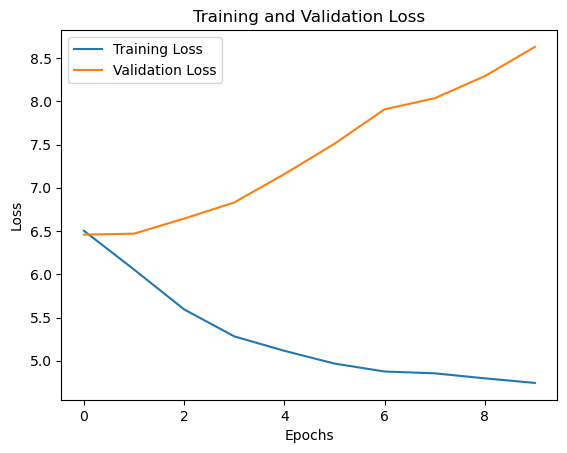

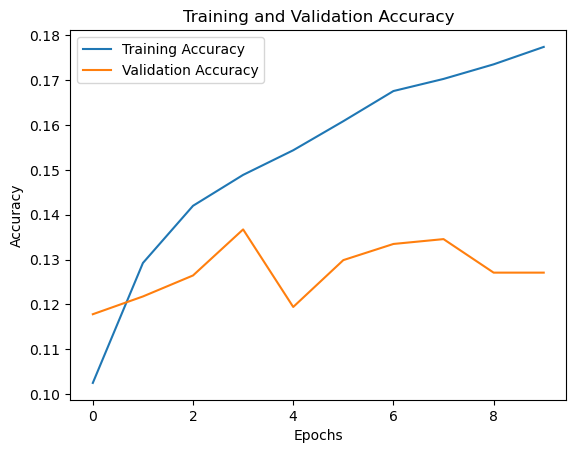

In [19]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
import pickle
tokenizer_file_path = r"C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle"
try:
    
    pickle.dump(tokenizer,open(tokenizer_file_path,'wb'))
    print(f"Tokenizer successfully saved to: {tokenizer_file_path}")  # Confirm success
except Exception as e:
    print(f"Error saving tokenizer: {e}")  # Print any error message
    # Handle the error (e.g., exit, raise an exception)

Tokenizer successfully saved to: C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle


code to make the tokenizer and loading the model

In [21]:
from tensorflow.keras.models import model_from_json, load_model
import pickle

# --- Load model weights and other components if architecture loaded successfully ---
if loaded_model is not None:
    try:
        # Load the model weights from the .h5 file
        loaded_model.load_weights('my_language_model.h5')  # Load the weights into the loaded model
        # Load the tokenizer
        tokenizer_file_path = r'C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle'
        print(f"Attempting to load tokenizer from: {tokenizer_file_path}")  # Debug
        if not os.path.exists(tokenizer_file_path):
            raise FileNotFoundError(f"Tokenizer file not found at: {tokenizer_file_path}")
        with open(tokenizer_file_path, 'rb') as handle:
            tokenizer = pickle.load(handle)
        print(f"pickle.load returned: {tokenizer}") # Debug
        if tokenizer is None:
            print("ERROR: pickle.load returned None!") #IMPORTANT
     
        max_sequence_len = 25
        print("Model architecture, weights, and tokenizer loaded successfully.")
    except Exception as e:
        print(f"Error loading model weights or tokenizer: {e}")
        # Optionally, you could set loaded_model = None here if loading weights fails
        #  depending on how you want your program to handle this scenario.
        tokenizer = None
        max_sequence_len = None
else:
  tokenizer = None
  max_sequence_len = None
print(f"Tokenizer: {tokenizer}")
print(f"Max Sequence Length: {max_sequence_len}")

Attempting to load tokenizer from: C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle
pickle.load returned: <keras.src.legacy.preprocessing.text.Tokenizer object at 0x000001B35C8834D0>
Model architecture, weights, and tokenizer loaded successfully.
Tokenizer: <keras.src.legacy.preprocessing.text.Tokenizer object at 0x000001B35C8834D0>
Max Sequence Length: 25


In [22]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

In [26]:
import tkinter as tk
from tkinter import ttk, messagebox, Button
import pyttsx3
import googletrans
import threading
import time
import random
import traceback  # Import traceback for detailed error logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import os
from tkinter import Tk, scrolledtext, Button, Frame,Toplevel, END, INSERT

try:
    # --- Load your trained model and tokenizer ---
    model = load_model('my_language_model.h5')  # replace with your actual model file
    with open('tokenizer.pickle', 'rb') as handle:
       tokenizer = pickle.load(handle)
    max_sequence_len = 25  # replace with the actual value used during training
except ImportError:
    print("Error: TensorFlow and/or pickle are not installed. Please install them to run this application.")
    model = None
    tokenizer = None
    max_sequence_len = 0
except FileNotFoundError:
    print("Error: Model or tokenizer file not found. Please ensure the paths are correct.")
    model = None
    tokenizer = None
    max_sequence_len = 0 
# --- old Prediction Function ---
def predict_top_five_words(model, tokenizer, seed_text, max_sequence_len):
    print(f"predict_top_five_words called with seed_text: '{seed_text}'")
    if model is None:
        print("ERROR: Model is None in predict_top_five_words!")
        return []  # Important: Return an empty list if model is None
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    print(f"top_five_words: {top_five_words}")
    return top_five_words

def show_predictions(event=None):
    if model is None or tokenizer is None:
        return

    current_text = input_text.get("1.0", tk.END).strip()
    if not current_text:
        hide_predictions()
        return

    cursor_index = input_text.index(tk.INSERT)
    line, char = map(int,cursor_index.split('.'))
    prefix_text = input_text.get(f"{line}.0", cursor_index).strip()

    if prefix_text:
        top_words = predict_top_five_words(model, tokenizer, prefix_text, max_sequence_len)
        display_floating_predictions(top_words, cursor_index)
    else:
        hide_predictions()


def add_word(word):
    cursor_index_before_insert = input_text.index(tk.INSERT)
    input_text.insert(cursor_index_before_insert, f" {word}")

    # Calculate the new cursor position
    line, char = map(int, cursor_index_before_insert.split('.'))
    new_char = char + len(word) + 1
    input_text.mark_set(tk.INSERT, f"{line}.{new_char}")
    input_text.see(tk.INSERT)  # Ensure the inserted text is visible

    root.after(100, show_predictions) # Delay prediction update
    hide_predictions() # Hide the floating window after selection

floating_predictions_window = None

def display_floating_predictions(words, cursor_index):
    global floating_predictions_window

    hide_predictions() # Hide any existing prediction window

    if words:
        floating_predictions_window = Toplevel(root)
        floating_predictions_window.transient(root) # Make it dependent on the main window
        # floating_predictions_window.grab_set() # Temporarily remove grab_set

        # Get cursor coordinates
        x, y, _, _ = input_text.bbox(cursor_index)
        if x is not None and y is not None:  # Check if bbox returns None
            text_x, text_y = input_text.winfo_rootx(), input_text.winfo_rooty()
            prediction_x = text_x + x
            prediction_y = text_y + y + 20  # Adjust vertical position

            floating_predictions_window.geometry(f"+{prediction_x}+{prediction_y}")
            floating_predictions_window.overrideredirect(True)  # Remove window decorations

            for i, word in enumerate(words):
                button = Button(floating_predictions_window, text=word, command=lambda w=word: add_word(w))
                button.pack(side="left", padx=2, pady=2)

            floating_predictions_window.deiconify()  # Ensure the window is visible
            floating_predictions_window.lift()  # Bring it to the front
        else:
            print("Warning: input_text.bbox(cursor_index) returned None.  Not displaying predictions.")


def hide_predictions(event=None):
    global floating_predictions_window
    if floating_predictions_window:
        floating_predictions_window.destroy()
        floating_predictions_window = None


# Initialize TTS engine and translator
tts = pyttsx3.init()
translator = googletrans.Translator()



# List of supported languages and their codes
language_options = {
    "Amharic": "am", "Arabic": "ar", "Armenian": "hy", "Azerbaijani": "az",
    "Belarusian": "be", "Bengali": "bn", "Bulgarian": "bg", "Burmese": "my",
    "Catalan": "ca", "Cebuano": "ceb", "Chichewa": "ny", "Chinese": "zh-CN",
    "Corsican": "co", "Czech": "cs", "Dari": "prs", "Dutch": "nl", "English": "en",
    "Esperanto": "eo", "Estonian": "et", "Finnish": "fi", "Flemish": "nl",
    "French": "fr", "Ga": "ga", "Georgian": "ka", "German": "de", "Greek": "el",
    "Gujarati": "gu", "Hausa": "ha", "Hawaiian Creole": "haw", "Hebrew": "he",
    "Hindi": "hi", "Hmong": "hmn", "Hungarian": "hu", "Icelandic": "is",
    "Igbo": "ig", "Indonesian": "id", "Irish": "ga", "Italian": "it",
    "Japanese": "ja", "Javanese": "jv", "Kannada": "kn", "Kazakh": "kk",
    "Khmer": "km", "Korean": "ko", "Kurdish": "ku", "Kyrgyz": "ky",
    "Lao": "lo", "Latin": "la", "Latvian": "lv", "Lithuanian": "lt",
    "Luxembourgish": "lb", "Macedonian": "mk", "Malagasy": "mg", "Malay": "ms",
    "Malayalam": "ml", "Maltese": "mt", "Maori": "mi", "Marathi": "mr",
    "Mongolian": "mn", "Nepali": "ne", "Norwegian": "no", "Pashto": "ps",
    "Persian": "fa", "Polish": "pl", "Portuguese": "pt", "Punjabi": "pa",
    "Romanian": "ro", "Russian": "ru", "Samoan": "sm", "Scottish Gaelic": "gd",
    "Serbian": "sr", "Shona": "sn", "Sindhi": "sd", "Sinhala": "si",
    "Slovak": "sk", "Slovenian": "sl", "Somali": "so", "Sotho": "st",
    "Spanish": "es", "Sundanese": "su", "Swahili": "sw", "Swedish": "sv",
    "Tagalog": "tl", "Tajik": "tg", "Tamil": "ta", "Telugu": "te",
    "Thai": "th", "Tibetan": "bo", "Turkish": "tr", "Turkmen": "tk",
    "Ukrainian": "uk", "Urdu": "ur", "Uzbek": "uz", "Vietnamese": "vi",
    "Welsh": "cy", "West Frisian": "fy", "Xhosa": "xh", "Yiddish": "yi",
    "Yoruba": "yo", "Zulu": "zu"
}

# Create the main window
root = tk.Tk()
root.title("PLAY~TTS")
root.geometry("400x600")  # Increased height to accommodate output box
root.configure(bg="#f0ffff")

# Header
header = tk.Label(root, text="🟩PLAY~TTS", font=("Helvetica", 18, "bold"), bg="#f8f8f8")
header.pack(pady=10)

# Tabs (keeping for potential future use)
tab_frame = tk.Frame(root, bg="#f0ffff")
tab_frame.pack(pady=5)

open_audio_btn = tk.Button(tab_frame, text="Text to Speech", bg="#d1d1d1", width=20)
open_audio_btn.grid(row=0, column=0, padx=2)  # No command, as discussed

# Settings
settings_label = tk.Label(root, text="Settings", font=("Helvetica", 12, "bold"), bg="#f0ffff")
settings_label.pack(pady=10)

# Language Dropdown
language_label = tk.Label(root, text="Target Language:", bg="#f3e8ff")
language_label.pack()
language_var = tk.StringVar()
languages = sorted(language_options.keys())
language_dropdown = ttk.Combobox(root, textvariable=language_var, values=languages)
language_dropdown.set("English")  # Set default to English
language_dropdown.pack(pady=5)


# Voice Dropdown
voice_label = tk.Label(root, text="Voice:", bg="#f8f8f8")
voice_label.pack()
voice_var = tk.StringVar()
voices = ["Male", "Female"]
voice_dropdown = ttk.Combobox(root, textvariable=voice_var, values=voices)
voice_dropdown.set("Male")  # Set default to Male
voice_dropdown.pack(pady=5)

# Voice Settings Dropdown
voice_settings_label = tk.Label(root, text="Voice Settings:", bg="#f8f8f8")
voice_settings_label.pack()
voice_settings_dropdown = ttk.Combobox(root, values=["Fast", "Medium", "Slow"])
voice_settings_dropdown.set("Medium")  # Set default to Medium
voice_settings_dropdown.pack(pady=5)

# Input Text Box
input_text_label = tk.Label(root, text="Input Text", bg="#f8f8f8")
input_text_label.pack()
input_text = scrolledtext.ScrolledText(root, height=5, width=40)
input_text.insert(tk.END, "Type or paste text here.")
input_text.pack(pady=5)

# Bind text input event to show predictions
input_text.bind("<KeyRelease>", show_predictions)
input_text.bind("<Button-1>", show_predictions) # Update predictions on mouse click (cursor change)
input_text.bind("<FocusOut>", hide_predictions)
show_predictions()
# Output Text Box
output_text_label = tk.Label(root, text="Translated Text", bg="#e0ffe0")
output_text_label.pack()
output_text = tk.Text(root, height=5, width=40, state=tk.DISABLED)  # Disabled for display
output_text.pack(pady=5)

# Token Counter & Quota
quota_label = tk.Label(root, text="0 / 500 \u00A0\u00A0\u00A0\u00A0Total quota remaining: 50", bg="#f8f8f8")
quota_label.pack()


def translate_text_output():
    """Translates the input text and displays it in the output text box."""
    text = input_text.get("1.0", "end-1c").strip()
    language = language_var.get()

    if language in language_options:
        try:
            translated_text = translator.translate(text, dest=language_options[language]).text
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, translated_text)
            output_text.config(state=tk.DISABLED)
        except googletrans.exceptions.Exception as e:
            error_message = f"Translation Error for {language}:\n{e}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
        except Exception as e:
            error_message = f"An unexpected error occurred during translation:\n{e}\n{traceback.format_exc()}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
    else:
        output_text.config(state=tk.NORMAL)
        output_text.delete("1.0", tk.END)
        output_text.insert(tk.END, text)  # If language not in options, show original
        output_text.config(state=tk.DISABLED)



def speak_humanized(text, rate=150, target_textbox=None):
    """Speaks text with slight pauses and rate variations, highlighting in the target textbox."""
    tts.setProperty('rate', rate)
    sentences = text.split('.')
    spoken_text_index = 0
    for sentence in sentences:
        words = sentence.strip().split()
        for i, word in enumerate(words):
            try:
                tts.say(word)
                if target_textbox:
                    start_index = text.find(word, spoken_text_index)
                    if start_index != -1:
                        end_index = start_index + len(word)
                        target_textbox.tag_add("speaking", f"1.{start_index}", f"1.{end_index}")
                        target_textbox.see(f"1.{start_index}")
                        spoken_text_index = end_index + 1
                tts.runAndWait()
            except Exception as e:
                error_message = f"Error during speech synthesis:\n{e}\n{traceback.format_exc()}"
                messagebox.showerror("Speech Error", error_message)
                return  # Stop speaking on error
            if target_textbox:
                target_textbox.tag_remove("speaking", "1.0", "end")
            if i < len(words) - 1 and ',' in sentence:
                time.sleep(0.05)  # Short pause at commas
            elif i == len(words) - 1 and sentence.strip():
                time.sleep(0.1)  # Slightly longer pause at sentence end



def speaknow():
    """
    Function to speak the translated text from the output text box with selected options,
    and highlight words in the output text box as they are spoken.
    """
    translated_text = output_text.get("1.0", "end-1c").strip()
    gender = voice_var.get()
    speed = voice_settings_dropdown.get()
    voices = tts.getProperty('voices')

    def setvoice():
        """Sets the voice based on the selected gender."""
        male_voice_id = None
        female_voice_id = None
        for voice in voices:
            if hasattr(voice, 'gender'):
                if voice.gender == 'male':
                    male_voice_id = voice.id
                elif voice.gender == 'female':
                    female_voice_id = voice.id
        if voice_var.get() == 'Female' and female_voice_id:
            tts.setProperty('voice', female_voice_id)
        elif voice_var.get() == 'Male' and male_voice_id:
            tts.setProperty('voice', male_voice_id)
        else:
            for voice in voices:
                if 'female' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            for voice in voices:
                if 'male' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            if voices:
                tts.setProperty('voice', voices[0].id)
                messagebox.showwarning("Voice Warning", "Could not determine voice gender. Using a default voice.")
            else:
                messagebox.showerror("TTS Error", "No voices available on your system.")

    if translated_text:
        # Adjust the speech rate
        if speed == 'Fast':
            tts.setProperty('rate', 200)
        elif speed == 'Medium':
            tts.setProperty('rate', 150)
        else:
            tts.setProperty('rate', 100)

        setvoice()
        output_text.tag_configure("speaking", background="blue", foreground="black")

        # Use a thread to prevent the GUI from freezing during highlighting and speech
        threading.Thread(target=speak_humanized, args=(translated_text, tts.getProperty('rate'), output_text)).start()
    else:
        messagebox.showwarning("No Text", "Please enter text and translate it first.")



# Bind the translation function to the "Text to Speech" button (renamed for clarity)
translate_button = Button(tab_frame, text="Translate", bg="#4CAF50", fg="white", width=20, command=translate_text_output)
translate_button.grid(row=0, column=1, padx=2)

# Generate Button (renamed to "Speak")
speak_btn = Button(root, text="Speak", bg="#666", fg="white", width=30, command=speaknow)
speak_btn.pack(pady=20)


def on_closing():
    """Handles the window close event."""
    if messagebox.askokcancel("Quit", "Do you want to quit?"):
        tts.stop()  # Stop the TTS engine
        root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)  # Set the close event handler

def clear_input_text(event):
    """Clears the input text box when it's first clicked."""
    if input_text.get("1.0", "end-1c").strip() == "Type or paste text here.":
        input_text.delete("1.0", tk.END)
        input_text.unbind('<FocusIn>', clear_input_text_id)  # Unbind after clearing once

clear_input_text_id = input_text.bind('<FocusIn>', clear_input_text) #stores the id, and is unbinded after the box is cleared.

root.mainloop()


predict_top_five_words called with seed_text: 'Type or paste text here.'
top_five_words: ['i', 'shouted', 'free', 'to', 'as']


TypeError: cannot unpack non-iterable NoneType object

using with enhanced output feature

In [ ]:
#################################################################
GOOD JOB @

In [11]:
import tkinter as tk
from tkinter import ttk, messagebox, Button
import pyttsx3
import googletrans
import threading
import time
import traceback  # Import traceback for detailed error logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import os
from tkinter import Tk, scrolledtext, Button, Frame, Toplevel, END, INSERT


try:
    # --- Load your trained model and tokenizer ---
    model = load_model('my_language_model.h5')  # replace with your actual model file
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    max_sequence_len = 25  # replace with the actual value used during training
except ImportError:
    print("Error: TensorFlow and/or pickle are not installed. Please install them to run this application.")
    model = None
    tokenizer = None
    max_sequence_len = 0
except FileNotFoundError:
    print("Error: Model or tokenizer file not found. Please ensure the paths are correct.")
    model = None
    tokenizer = None
    max_sequence_len = 0


# --- Prediction Function ---
def predict_top_five_words(model, tokenizer, seed_text, max_sequence_len):
    """Predicts the top five words following the given seed text."""
    print(f"predict_top_five_words called with seed_text: '{seed_text}'")
    if model is None:
        print("ERROR: Model is None in predict_top_five_words!")
        return []  # Important: Return an empty list if model is None
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    print(f"top_five_words: {top_five_words}")
    return top_five_words



def show_predictions(event=None):
    """Displays word predictions based on the current input text."""
    if model is None or tokenizer is None:
        return

    input_text_content = input_text.get("1.0", tk.END).strip()  # Changed variable name
    if not input_text_content:
        hide_predictions()
        return

    cursor_index = input_text.index(tk.INSERT)
    line, char = map(int, cursor_index.split('.'))
    seed_text = input_text.get(f"{line}.0", cursor_index).strip() # Changed variable name

    if seed_text:
        top_words = predict_top_five_words(model, tokenizer, seed_text, max_sequence_len)
        display_floating_predictions(top_words, cursor_index)
    else:
        hide_predictions()



def add_word(word):
    """Adds the selected word to the input text at the cursor position."""
    cursor_index_before_insert = input_text.index(tk.INSERT)
    input_text.insert(cursor_index_before_insert, f" {word}")

    # Calculate the new cursor position
    line, char = map(int, cursor_index_before_insert.split('.'))
    new_char = char + len(word) + 1
    input_text.mark_set(tk.INSERT, f"{line}.{new_char}")
    input_text.see(tk.INSERT)  # Ensure the inserted text is visible

    root.after(100, show_predictions)  # Delay prediction update
    hide_predictions()  # Hide the floating window after selection



floating_predictions_window = None



def display_floating_predictions(words, cursor_index):
    """Displays a floating window with word predictions."""
    global floating_predictions_window

    hide_predictions()  # Hide any existing prediction window

    if words:
        floating_predictions_window = Toplevel(root)
        floating_predictions_window.transient(root)  # Make it dependent on the main window

        # Get cursor coordinates
        bbox = input_text.bbox(cursor_index)  # Store the result of bbox()
        if bbox is not None:
            x, y, _, _ = bbox
            text_x, text_y = input_text.winfo_rootx(), input_text.winfo_rooty()
            prediction_x = text_x + x
            prediction_y = text_y + y + 20  # Adjust vertical position

            floating_predictions_window.geometry(f"+{prediction_x}+{prediction_y}")
            floating_predictions_window.overrideredirect(True)  # Remove window decorations

            for i, word in enumerate(words):
                button = Button(floating_predictions_window, text=word, command=lambda w=word: add_word(w))
                button.pack(side="left", padx=2, pady=2)

            floating_predictions_window.deiconify()  # Ensure the window is visible
            floating_predictions_window.lift()  # Bring it to the front
        else:
            print("Warning: input_text.bbox(cursor_index) returned None.  Not displaying predictions.")



def hide_predictions(event=None):
    """Hides the floating prediction window."""
    global floating_predictions_window
    if floating_predictions_window:
        floating_predictions_window.destroy()
        floating_predictions_window = None


# Initialize TTS engine and translator
tts = pyttsx3.init()
translator = googletrans.Translator()

# List of supported languages and their codes
language_options = {
    "Amharic": "am", "Arabic": "ar", "Armenian": "hy", "Azerbaijani": "az",
    "Belarusian": "be", "Bengali": "bn", "Bulgarian": "bg", "Burmese": "my",
    "Catalan": "ca", "Cebuano": "ceb", "Chichewa": "ny", "Chinese": "zh-CN",
    "Corsican": "co", "Czech": "cs", "Dari": "prs", "Dutch": "nl", "English": "en",
    "Esperanto": "eo", "Estonian": "et", "Finnish": "fi", "Flemish": "nl",
    "French": "fr", "Ga": "ga", "Georgian": "ka", "German": "de", "Greek": "el",
    "Gujarati": "gu", "Hausa": "ha", "Hawaiian Creole": "haw", "Hebrew": "he",
    "Hindi": "hi", "Hmong": "hmn", "Hungarian": "hu", "Icelandic": "is",
    "Igbo": "ig", "Indonesian": "id", "Irish": "ga", "Italian": "it",
    "Japanese": "ja", "Javanese": "jv", "Kannada": "kn", "Kazakh": "kk",
    "Khmer": "km", "Korean": "ko", "Kurdish": "ku", "Kyrgyz": "ky",
    "Lao": "lo", "Latin": "la", "Latvian": "lv", "Lithuanian": "lt",
    "Luxembourgish": "lb", "Macedonian": "mk", "Malagasy": "mg", "Malay": "ms",
    "Malayalam": "ml", "Maltese": "mt", "Maori": "mi", "Marathi": "mr",
    "Mongolian": "mn", "Nepali": "ne", "Norwegian": "no", "Pashto": "ps",
    "Persian": "fa", "Polish": "pl", "Portuguese": "pt", "Punjabi": "pa",
    "Romanian": "ro", "Russian": "ru", "Samoan": "sm", "Scottish Gaelic": "gd",
    "Serbian": "sr", "Shona": "sn", "Sindhi": "sd", "Sinhala": "si",
    "Slovak": "sk", "Slovenian": "sl", "Somali": "so", "Sotho": "st",
    "Spanish": "es", "Sundanese": "su", "Swahili": "sw", "Swedish": "sv",
    "Tagalog": "tl", "Tajik": "tg", "Tamil": "ta", "Telugu": "te",
    "Thai": "th", "Tibetan": "bo", "Turkish": "tr", "Turkmen": "tk",
    "Ukrainian": "uk", "Urdu": "ur", "Uzbek": "uz", "Vietnamese": "vi",
    "Welsh": "cy", "West Frisian": "fy", "Xhosa": "xh", "Yiddish": "yi",
    "Yoruba": "yo", "Zulu": "zu"
}

# Create the main window
root = tk.Tk()
root.title("PLAY~TTS")
root.geometry("400x600")  # Increased height to accommodate output box
root.configure(bg="#f0ffff")

# Header
header = tk.Label(root, text="🟩PLAY~TTS", font=("Helvetica", 18, "bold"), bg="#f8f8f8")
header.pack(pady=10)

# Tabs (keeping for potential future use)
tab_frame = tk.Frame(root, bg="#f0ffff")
tab_frame.pack(pady=5)

open_audio_btn = tk.Button(tab_frame, text="Text to Speech", bg="#d1d1d1", width=20)
open_audio_btn.grid(row=0, column=0, padx=2)  # No command, as discussed

# Settings
settings_label = tk.Label(root, text="Settings", font=("Helvetica", 12, "bold"), bg="#f0ffff")
settings_label.pack(pady=10)

# Language Dropdown
language_label = tk.Label(root, text="Target Language:", bg="#f3e8ff")
language_label.pack()
language_var = tk.StringVar()
languages = sorted(language_options.keys())
language_dropdown = ttk.Combobox(root, textvariable=language_var, values=languages)
language_dropdown.set("English")  # Set default to English
language_dropdown.pack(pady=5)


# Voice Dropdown
voice_label = tk.Label(root, text="Voice:", bg="#f8f8f8")
voice_label.pack()
voice_var = tk.StringVar()
voices = ["Male"]
voice_dropdown = ttk.Combobox(root, textvariable=voice_var, values=voices)
voice_dropdown.set("Male")  # Set default to Male
voice_dropdown.pack(pady=5)

# Voice Settings Dropdown
voice_settings_label = tk.Label(root, text="Voice Settings:", bg="#f8f8f8")
voice_settings_label.pack()
voice_settings_dropdown = ttk.Combobox(root, values=["Fast", "Medium", "Slow"])
voice_settings_dropdown.set("Medium")  # Set default to Medium
voice_settings_dropdown.pack(pady=5)

# Input Text Box
input_text_label = tk.Label(root, text="Input Text", bg="#f8f8f8")
input_text_label.pack()
input_text = scrolledtext.ScrolledText(root, height=5, width=40)
input_text.insert(tk.END, "Type or paste text here.")
input_text.pack(pady=5)

# Bind text input event to show predictions
input_text.bind("<KeyRelease>", show_predictions)
input_text.bind("<Button-1>", show_predictions)  # Update predictions on mouse click (cursor change)
input_text.bind("<FocusOut>", hide_predictions)
show_predictions()
# Output Text Box
output_text_label = tk.Label(root, text="Translated Text", bg="#e0ffe0")
output_text_label.pack()
output_text = tk.Text(root, height=5, width=40, state=tk.DISABLED)  # Disabled for display
output_text.pack(pady=5)

# Token Counter & Quota
quota_label = tk.Label(root, text="0 / 500 \u00A0\u00A0\u00A0\u00A0Total quota remaining: 50", bg="#f8f8f8")
quota_label.pack()


def translate_text_output():
    """Translates the input text and displays it in the output text box."""
    text = input_text.get("1.0", "end-1c").strip()
    language = language_var.get()

    if language in language_options:
        try:
            translated_text = translator.translate(text, dest=language_options[language]).text
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, translated_text)
            output_text.config(state=tk.DISABLED)
        except googletrans.exceptions.HTTPError as e:
            error_message = f"Translation Error (HTTP):\n{e}\nPossible network issue. Please check your connection and try again."
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed due to a network issue.")
            output_text.config(state=tk.DISABLED)
        except googletrans.exceptions.ConnectTimeout as e:
            error_message = f"Translation Error (Timeout):\n{e}\nNetwork connection timed out. Please check your connection and try again."
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed due to a network timeout.")
            output_text.config(state=tk.DISABLED)
        except googletrans.exceptions.Exception as e:
            error_message = f"Translation Error for {language}:\n{e}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
        except Exception as e:
            error_message = f"An unexpected error occurred during translation:\n{e}\n{traceback.format_exc()}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
    else:
        output_text.config(state=tk.NORMAL)
        output_text.delete("1.0", tk.END)
        output_text.insert(tk.END, text)  # If language not in options, show original
        output_text.config(state=tk.DISABLED)

'''def translate_text_output():
    """Translates the input text and displays it in the output text box."""
    text = input_text.get("1.0", "end-1c").strip()
    language = language_var.get()

    if language in language_options:
        try:
            translated_text = translator.translate(text, dest=language_options[language]).text
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, translated_text)
            output_text.config(state=tk.DISABLED)
        except googletrans.exceptions.Exception as e:
            error_message = f"Translation Error for {language}:\n{e}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
        except Exception as e:
            error_message = f"An unexpected error occurred during translation:\n{e}\n{traceback.format_exc()}"
            messagebox.showerror("Translation Error", error_message)
            output_text.config(state=tk.NORMAL)
            output_text.delete("1.0", tk.END)
            output_text.insert(tk.END, "Translation failed.")
            output_text.config(state=tk.DISABLED)
    else:
        output_text.config(state=tk.NORMAL)
        output_text.delete("1.0", tk.END)
        output_text.insert(tk.END, text)  # If language not in options, show original
        output_text.config(state=tk.DISABLED)'''



def speak_humanized(text, rate=150, target_textbox=None):
    """Speaks text with slight pauses and rate variations, highlighting in the target textbox."""
    tts.setProperty('rate', rate)
    sentences = text.split('.')
    spoken_text_index = 0
    for sentence in sentences:
        words = sentence.strip().split()
        for i, word in enumerate(words):
            try:
                tts.say(word)
                if target_textbox:
                    start_index = text.find(word, spoken_text_index)
                    if start_index != -1:
                        end_index = start_index + len(word)
                        target_textbox.tag_add("speaking", f"1.{start_index}", f"1.{end_index}")
                        target_textbox.see(f"1.{start_index}")
                        spoken_text_index = end_index + 1
                tts.runAndWait()
            except Exception as e:
                error_message = f"Error during speech synthesis:\n{e}\n{traceback.format_exc()}"
                messagebox.showerror("Speech Error", error_message)
                return  # Stop speaking on error
        if target_textbox:
           target_textbox.tag_remove("speaking", "1.0", "end")
        if i < len(words) - 1 and ',' in sentence:
            time.sleep(0.05)  # Short pause at commas
        elif i == len(words) - 1 and sentence.strip():
            time.sleep(0.1)  # Slightly longer pause at sentence end'''



def speaknow():
    """
    Function to speak the translated text from the output text box with selected options,
    and highlight words in the output text box as they are spoken.
    """
    translated_text = output_text.get("1.0", "end-1c").strip()
    gender = voice_var.get()
    speed = voice_settings_dropdown.get()
    voices = tts.getProperty('voices')

    def setvoice():
        """Sets the voice based on the selected gender."""
        male_voice_id = None
        female_voice_id = None
        for voice in voices:
            if hasattr(voice, 'gender'):
                if voice.gender == 'male':
                    male_voice_id = voice.id
                elif voice.gender == 'female':
                    female_voice_id = voice.id
        if voice_var.get() == 'Female' and female_voice_id:
            tts.setProperty('voice', female_voice_id)
        elif voice_var.get() == 'Male' and male_voice_id:
            tts.setProperty('voice', male_voice_id)
        else:
            for voice in voices:
                if 'female' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            for voice in voices:
                if 'male' in voice.name.lower():
                    tts.setProperty('voice', voice.id)
                    return
            if voices:
                tts.setProperty('voice', voices[0].id)
                messagebox.showwarning("Voice Warning", "Could not determine voice gender. Using a default voice.")
            else:
                messagebox.showerror("TTS Error", "No voices available on your system.")
                return False #Indicate Failure
        return True #Indicate Success
    

    if translated_text:
        # Adjust the speech rate
        if speed == 'Fast':
            tts.setProperty('rate', 200)
        elif speed == 'Medium':
            tts.setProperty('rate', 150)
        else:
            tts.setProperty('rate', 100)

        if not setvoice():
            return

        output_text.tag_configure("speaking", background="blue", foreground="black")
        threading.Thread(target=speak_and_highlight, args=(translated_text, output_text)).start()
    else:
        messagebox.showwarning("No Text", "Please enter text and translate it first.")
    
def speak_and_highlight(text, target_textbox):
    """
    Speaks the given text and highlights it in the target textbox.
    This function is intended to be run in a separate thread.
    """
    rate = tts.getProperty('rate')
    tts.setProperty('rate', rate)
    words = text.split()
    spoken_text_index = 0
    target_textbox.tag_configure("speaking", background="blue", foreground="black")

    for word in words:
        try:
            tts.say(word)
            start_index = text.find(word, spoken_text_index)
            if start_index != -1:
                end_index = start_index + len(word)
                # Apply highlighting in the main thread
                root.after(0, lambda s=start_index, e=end_index: target_textbox.tag_add("speaking", f"1.{s}", f"1.{e}"))
                root.after(0, lambda s=start_index: target_textbox.see(f"1.{s}"))
                spoken_text_index = end_index + 1
            tts.runAndWait()
            # Remove highlighting after the word is spoken (with a small delay for visual effect)
            root.after(100, lambda s=start_index, e=end_index: target_textbox.tag_remove("speaking", f"1.{s}", f"1.{e}"))
            time.sleep(0.05)  # Small pause between words
        except Exception as e:
            error_message = f"Error during speech synthesis:\n{e}\n{traceback.format_exc()}"
            print(error_message)
            root.after(0, lambda: messagebox.showerror("Speech Error", error_message))
            return

    # Ensure all highlighting is removed at the end
    root.after(0, lambda: target_textbox.tag_remove("speaking", "1.0", "end"))
    '''rate = tts.getProperty('rate')
    tts.setProperty('rate', rate)
    sentences = text.split('.')
    spoken_text_index = 0
    for sentence in sentences:
        words = sentence.strip().split()
        for i, word in enumerate(words):
            try:
                tts.say(word)
                if target_textbox:
                    start_index = text.find(word, spoken_text_index)
                    if start_index != -1:
                        end_index = start_index + len(word)
                        target_textbox.tag_add("speaking", f"1.{start_index}", f"1.{end_index}")
                        target_textbox.see(f"1.{start_index}")
                        spoken_text_index = end_index + len(word)
                tts.runAndWait()
            except Exception as e:
                error_message = f"Error during speech synthesis:\n{e}\n{traceback.format_exc()}"
                print(error_message)
                root.after(0, lambda: messagebox.showerror("Speech Error", error_message))
                return  # Stop speaking on error
        if target_textbox:
            target_textbox.tag_remove("speaking", "1.0", "end")
        if i < len(words) - 1 and ',' in sentence:
            time.sleep(0.05)
        elif i == len(words) - 1 and sentence.strip():
            time.sleep(0.1)'''

# Bind the translation function to the "Text to Speech" button (renamed for clarity)
translate_button = Button(tab_frame, text="Translate", bg="#4CAF50", fg="white", width=20, command=translate_text_output)
translate_button.grid(row=0, column=1, padx=2)

# Generate Button (renamed to "Speak")
speak_btn = Button(root, text="Speak", bg="#666", fg="white", width=30, command=speaknow)
speak_btn.pack(pady=20)



def on_closing():
    """Handles the window close event."""
    if messagebox.askokcancel("Quit", "Do you want to quit?"):
        tts.stop()  # Stop the TTS engine
        root.destroy()


root.protocol("WM_DELETE_WINDOW", on_closing)  # Set the close event handler


def clear_input_text(event):
    """Clears the input text box when it's first clicked."""
    if input_text.get("1.0", "end-1c").strip() == "Type or paste text here.":
        input_text.delete("1.0", tk.END)
        input_text.unbind('<FocusIn>', clear_input_text_id)  # Unbind after clearing once


clear_input_text_id = input_text.bind('<FocusIn>', clear_input_text)  # stores the id, and is unbinded after the box is cleared.

root.mainloop()


predict_top_five_words called with seed_text: 'Type or paste text here.'
top_five_words: ['i', 'shouted', 'free', 'to', 'as']
predict_top_five_words called with seed_text: 'Type or paste text here.'
top_five_words: ['i', 'shouted', 'free', 'to', 'as']
predict_top_five_words called with seed_text: 'i'
top_five_words: ['hope', 'am', 'think', 'cannot', 'must']
predict_top_five_words called with seed_text: 'i cannot'
top_five_words: ['make', 'take', 'start', 'get', 'look']
predict_top_five_words called with seed_text: 'i cannot start'
top_five_words: ['the', 'it', 'for', 'out', 'but']
predict_top_five_words called with seed_text: 'i cannot start out'
top_five_words: ['riding', 'of', 'and', 'to', 'the']
predict_top_five_words called with seed_text: 'i cannot start out and'
top_five_words: ['the', 'mr', 'tom', 'anchored', 'cheerful']
predict_top_five_words called with seed_text: 'i cannot start out and tom'
top_five_words: ['hanging', 'looked', 'stuck', 'watched', 'as']
predict_top_five_word

KeyboardInterrupt: 